## Intermediate data reading and interactive visualization



Today we will learn how to read data from Excel files, and then to build interactive graphics of the data.



## Reading loosely structured data from Excel



Today we will learn how to read "loosely structured data". This data was obtained from the Gellman research group, and it is in an Excel file. Each sheet in the file contains an XPS spectrum at 169 different points on a curved single crystal. Our goals today are:

1.  Read the data into a set of arrays
2.  Plot the data
3.  Create interactive plots that allow us to select an (x, y) point and show the corresponding XPS spectrum.



In [1]:
url = 'https://drive.google.com/uc?id=10PtumF5esk4Q1uNf9-K_dPVigWHEUShJ'

import urllib.request
urllib.request.urlretrieve(url, 'XPS_Data.xlsx')

('XPS_Data.xlsx', <http.client.HTTPMessage at 0x2d589e80648>)

Open this file and inspect it.



### Planning out the arrays



We should come up with a plan for reading the data into arrays. Why? Because there are a lot of arrays and we want to make sure we get them in the right shape. If you open the file, you will see that it is not structured as only *rows* of data. There is a section at the top that looks like:

[img src="./screenshots/date-23-03-2020-time-06-40-59.png"](img src="./screenshots/date-23-03-2020-time-06-40-59.png")

Which tells us we have 31 elements in the Binding energy column, and 169 positions.

Next, we look at where the position data is. The x-data starts in row 11, and y in row 12. The binding energy, in contrast is in column A starting in row 15, and the counts start in column C.

[img src="./screenshots/date-23-03-2020-time-06-41-27.png"](img src="./screenshots/date-23-03-2020-time-06-41-27.png")

So, we need arrays for `x`, `y`, `BE`, `counts`, and from these we can visualize the data.



### Reading the Excel file with openpyxl



We will use [openpyxl](https://openpyxl.readthedocs.io/en/stable/index.html) to read this data in from the first sheet. If this next cell doesn't work, you may need to install it like this:



In [2]:
!pip install openpyxl

  Created wheel for et-xmlfile: filename=et_xmlfile-1.0.1-py3-none-any.whl size=8920 sha256=9435993a4d06e181dbc37d46c8d498c45dc543798f40ef635979d314f7b61fe9
  Stored in directory: c:\users\jqbon\appdata\local\pip\cache\wheels\e2\bd\55\048b4fd505716c4c298f42ee02dffd9496bb6d212b266c7f31
Successfully built et-xmlfile


Here we open the worksheet and load it.



In [5]:
import numpy as np
from openpyxl import load_workbook
wb = load_workbook(filename='XPS_Data.xlsx')
ws = wb.worksheets[0]  # get the first sheet

<Worksheet "0">

We can pretty easily get the number of energy and position values because they are single values in a cell.



In [4]:
nenergy = ws['D2'].value
npos = ws['D3'].value

(nenergy, npos)  # we show these to make sure they are right.

(31, 169)

Note I am working this out iteratively, one piece at a time. This is easier to debug.

Next we work out how to get the arrays of data. There is a lot packed into the next cell. To get a range of cells, we use the `iter_rows` function which lets us define a range by numeric rows and columns. This is convenient since we know how many points to get. This function returns a generator, so we convert it to a list, and then to an array. Note that this returns a column vector because we are iterating down a column, so we apply the squeeze function to reduce it to a 1D array.



In [6]:
v = np.array([[1],[2],[3],[4]])
v, v.shape

(array([[1],
        [2],
        [3],
        [4]]),
 (4, 1))

In [7]:
?np.squeeze

These are the same:



In [10]:
np.squeeze(v), v[:, 0]

(array([1, 2, 3, 4]), array([1, 2, 3, 4]))

So, back to getting the BEs. This makes a generator, which is a *lazy* iterator that doesn't do anything until you ask for it.



In [11]:
print(ws.iter_rows(min_row=15, max_row=15 + nenergy - 1,
                   min_col=1, max_col=1,
                   values_only=True))

<generator object Worksheet._cells_by_row at 0x000002D58C6D2A48>


We get the data by casting it as a list, which is like asking for all the data at once. Note this is a list of tuples, which is not that helpful.



In [12]:
list(ws.iter_rows(min_row=15, max_row=15 + nenergy - 1,
                  min_col=1, max_col=1,
                  values_only=True))

[(538,),
 (537.6,),
 (537.2,),
 (536.8,),
 (536.4,),
 (536,),
 (535.6,),
 (535.2,),
 (534.8,),
 (534.4,),
 (534,),
 (533.6,),
 (533.2,),
 (532.8,),
 (532.4,),
 (532,),
 (531.6,),
 (531.2,),
 (530.8,),
 (530.4,),
 (530,),
 (529.6,),
 (529.2,),
 (528.8,),
 (528.4,),
 (528,),
 (527.6,),
 (527.2,),
 (526.8,),
 (526.4,),
 (526,)]

So, finally, we turn it into an array, and squeeze off the last dimension to get a 1D array. Note it is common to iteratively write this cell like I did above, because there are a lot of operations happening in one variable assignment.



In [13]:
BE = np.array(list(ws.iter_rows(min_row=15, max_row=15 + nenergy - 1,
                                min_col=1, max_col=1,
                                values_only=True))).squeeze()
BE.shape, BE

((31,),
 array([538. , 537.6, 537.2, 536.8, 536.4, 536. , 535.6, 535.2, 534.8,
        534.4, 534. , 533.6, 533.2, 532.8, 532.4, 532. , 531.6, 531.2,
        530.8, 530.4, 530. , 529.6, 529.2, 528.8, 528.4, 528. , 527.6,
        527.2, 526.8, 526.4, 526. ]))

We apply a similar method to get the x, y points. This produces a 2D row array, which we also squeeze down to a 1D array.



In [14]:
x = np.array(list(ws.iter_rows(min_row=11, max_row=11,
                               min_col=3, max_col=3 + npos - 1,
                               values_only=True))).squeeze()

y = np.array(list(ws.iter_rows(min_row=12, max_row=12,
                               min_col=3, max_col=3 + npos - 1,
                               values_only=True))).squeeze()
x.shape, y.shape

((169,), (169,))

Finally, we need the counts. This will be a 2D array that should have 31 rows, and 169 columns. A column in this array corresponds to the XPS spectrum of the (x, y) point in the same column of the x, and y arrays.



In [15]:
counts = np.array(list(ws.iter_rows(min_row=15, max_row=15 + nenergy - 1,
                                    min_col=3, max_col=3 + npos - 1,
                                    values_only=True)))
counts.shape

(31, 169)

That concludes reading the data from the first sheet in. You can see that it is a lot more work than reading a simple csv or json file!



### First simple visualization



First, we plot the x,y points. These should look like concentric circles of points.



<IPython.core.display.Javascript object>


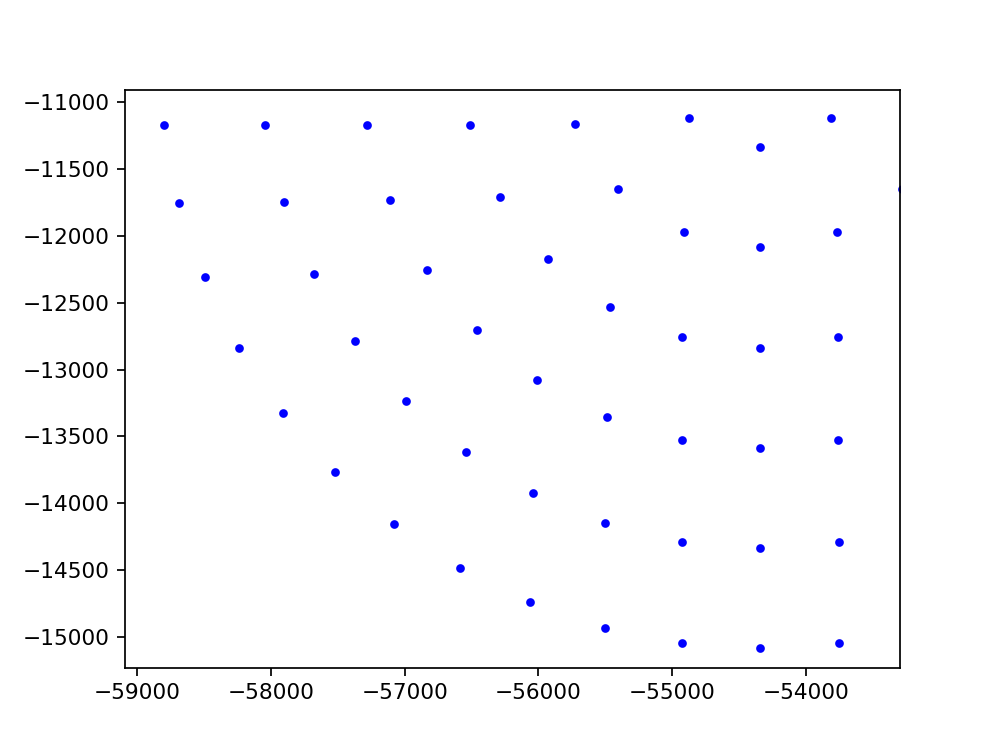

In [19]:
%matplotlib notebook
import matplotlib.pyplot as plt

plt.plot(x, y, 'b.')
plt.axis('equal');

Next we plot *all* the XPS plots. Since the counts are all in columns, we can plot all 169 of them at once. Each one of these curves corresponds to one point in the previous figure. It is convention to show the x-axis reversed, which we do by changing the x-limits. There are so many curves it is not helpful to put a legend on this.



<IPython.core.display.Javascript object>


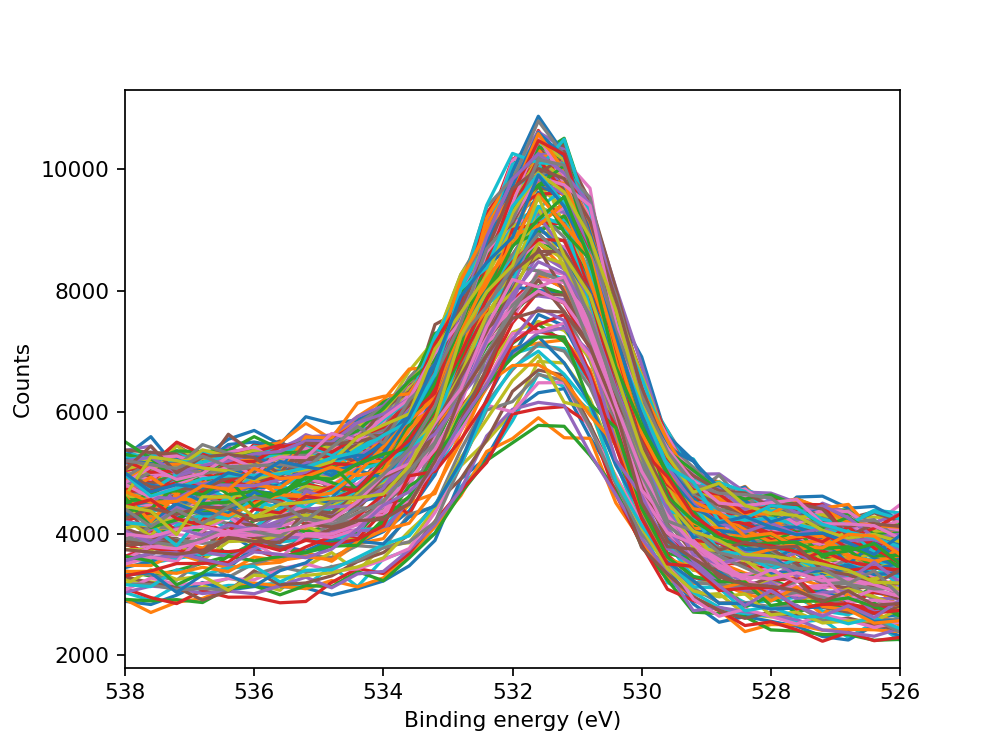

(538.0, 526.0)

In [20]:
plt.plot(BE, counts)
plt.xlabel('Binding energy (eV)')
plt.ylabel('Counts')
plt.xlim([BE.max(), BE.min()])  # this reverses the x-limits

## Introduction to interactive figures



The figures you have made so far are somewhat interactive. You can pan, zoom, etc., but they do not allow you to do many other things you might want to do like get information about a point or line, to click on one figure to update another one, etc. We are going to work our towards doing that.

First, we need a mental model of how an interactive figure works. A figure is shown in a graphic window, and that window can generate an *event*. That event may be something like a mouse-click, a key-press, or hover over, entering or leaving a figure, etc. Each of these events can be connected to a *callback* function which will be run with the event as an argument when an event occurs. This function is responsible for doing the interactive features you want.

So, the key idea we need to develop here is what events can we attach callback functions to, and how do we write callback functions to make the interactive features we want. We will focus exclusively on matplotlib because it allows us to write the callback functions in Python. There are several web-based tools for making interactive graphics that work in HTML files. I find these much more difficult to use, and they are much more limited because they are typically powered by javascript, which has limited ability to interact with files on your hard drive.



### Your first event - Mouse clicking



A [MouseEvent](https://matplotlib.org/3.1.0/api/backend_bases_api.html#matplotlib.backend_bases.MouseEvent) is triggered when a mouse button is pressed on a matplotlib figure. The event is an object that has several attributes:

-   **event.dblclick:** True if the event is a double-click
-   **event.button:** tells you which button was pressed
-   **event.key:** tells you if a key was also pressed, e.g. shift
-   **event.xdata:** The x-point you clicked on
-   **event.ydata:** The y-point you clicked on

Our first interactive figure will allow us to click on a figure and change the title of the plot with information about your click.

To do this, we need to change how we make plots. We will use `subplots` to generate a Figure and an
Axes, which we store in variables. Then, we can use these variables inside our callback functions to modify the plot properties.

First, we define the callback function.



In [24]:
def onclick(event):
    ax.set_title(f'''{'double' if event.dblclick else 'single'}
    event.button {event.button} key={event.key}
    click: button={event.button}, x={event.x}, y={event.y},
    xdata={event.xdata}, ydata={event.ydata}''')
    print(event)  # in Jupyter, you may not see any output depending on the backend you use.
    fig.canvas.draw() # Make sure you redraw the canvas to see the change

It is somewhat tricky to debug the callback functions in a jupyter notebook. The issue is that once the figure is made, it is controlled in a gui loop that is separate from the notebook, and it tends to ignore errors, and it also tends to suppress output.

One way we can try testing the callback function is to create a fake event that we can all here to see what is happening. This should work without any errors.

Let's see what a MouseEvent looks like.



In [22]:
import matplotlib
?matplotlib.backend_bases.MouseEvent

In [26]:
fig = matplotlib.figure.Figure()
fake_event = matplotlib.backend_bases.MouseEvent('test', fig.canvas, 0, 0)
fake_event

onclick(fake_event)

NameError: name 'ax' is not defined

Now, to use the callback function, we have to connect it to the canvas of the figure. Then, we just show the figure. Now, when you click on the figure you should see the title update indicating the properties of the click event.



<IPython.core.display.Javascript object>


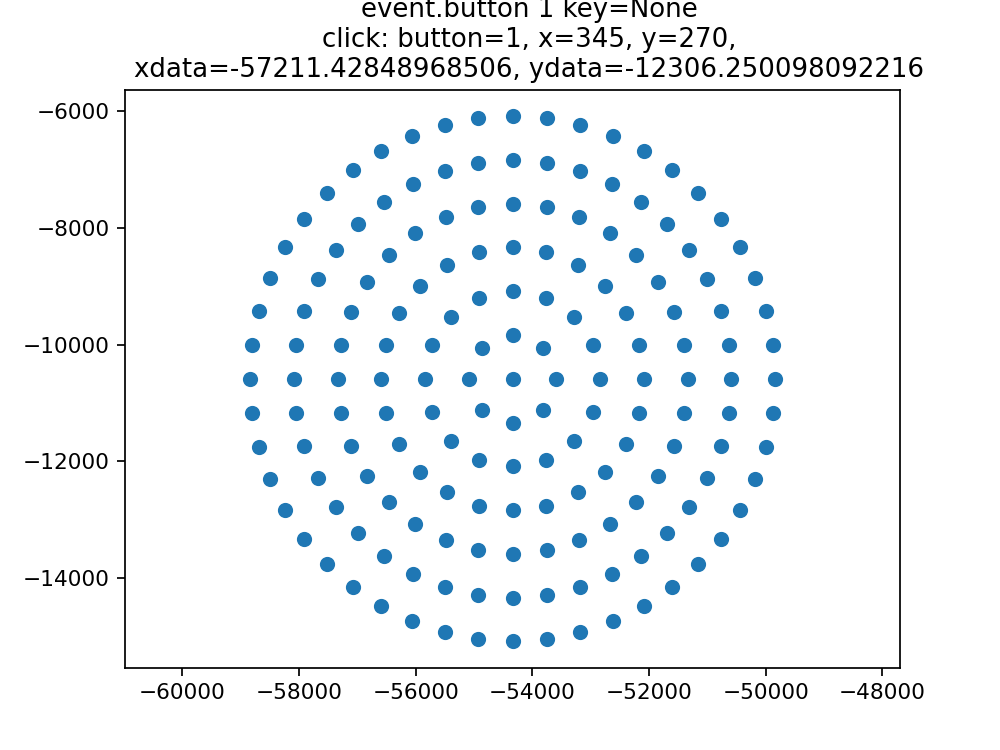

In [27]:
fig, ax = plt.subplots()

ax.scatter(x, y)
ax.axis('equal')

cid = fig.canvas.mpl_connect('button_press_event', onclick)
fig.show()

Try this out, and click in a few places, press some keys and click, and try double-clicking. Each one should update the figure. Note, however, in the notebook nothing gets printed. If you were running this in a script in a shell, you would see some output.

Congratulations, you have successfully made your first interactive graphic!



### Second event - adding points to a plot



Next, we add a way to add points to a plot. This might be to mark the point you clicked on, for example.

We still use a `button_press_event`. The goal is to add a blue square on a regular mouse click, and a red circle if you are pressing "r" when you click. We achieve this by using some logic in the event callback function to check if "r" is pressed. You can have as many of these if/else statements as you want.

We use the `event.key` attribute to see what key is pressed.



<IPython.core.display.Javascript object>


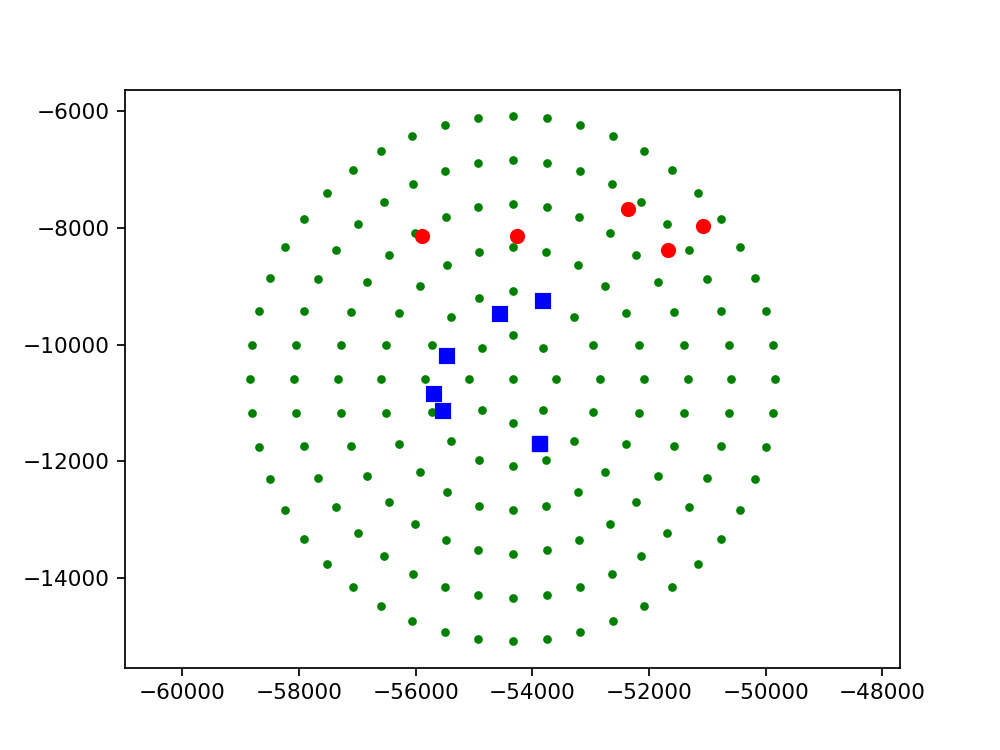

In [28]:
fig, ax = plt.subplots()
ax.plot(x, y, 'g.')
ax.axis('equal')

def onclick(event):
    if event.key == 'r':
        style = 'ro'
    else:
        style = 'bs'

    ax.plot([event.xdata], [event.ydata], style)
    fig.canvas.draw() # Make sure you redraw the canvas to see the change


cid = fig.canvas.mpl_connect('button_press_event', onclick)
fig.show()

### Third event - picking



One of the most useful events is called *picking*, which is an event that occurs when you click on a point or line in a plot. To enable picking, you have to add a `picker=N` argument to your plot, where `N` is a pixel radius, i.e. it will pick points within `N` pixels of where you click.

In a [PickEvent](https://matplotlib.org/3.1.0/api/backend_bases_api.html#matplotlib.backend_bases.PickEvent) you get all the regular attributes of an [Event](https://matplotlib.org/3.1.0/api/backend_bases_api.html#matplotlib.backend_bases.Event), and the following:

-   **event.mouseevent:** The mouse event that generated the pick
-   **event.artist:** The artist you picked
    -   This attribute also records what axis it is in.
-   **event.ind:** The index of the points that fall in the picked region. This will be a list, and it can have more than one point if they are close together.

Let's explore how this works. We will create two subplots, and use a callback function. There is only one callback function for the pick\_event, so we have to be able tell what was picked. We use the artist attached to the event to tell which axes were clicked on so we can update the correct title.



<IPython.core.display.Javascript object>


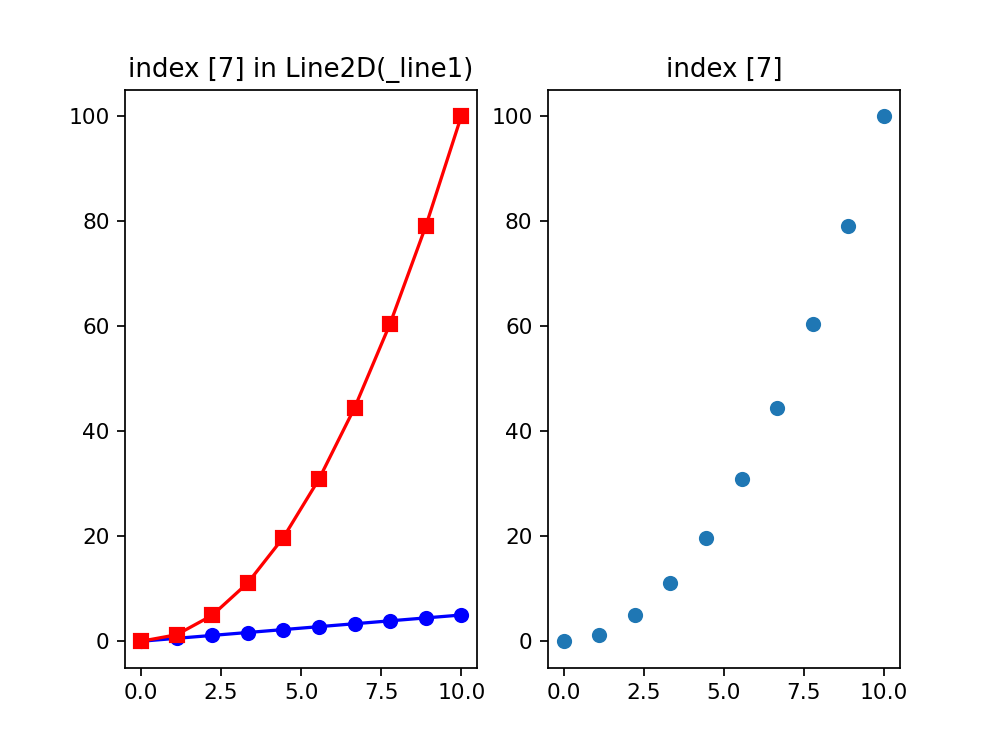

In [29]:
fig, (ax0, ax1) = plt.subplots(1, 2)

x = np.linspace(0, 10, 10)

ax0.plot(x, 0.5 * x, 'bo-', x, x**2, 'rs-', picker=5)
ax1.scatter(x, x**2, picker=5)

def onpick(event):
    if event.artist.axes == ax0:
        ax0.set_title(f'index {event.ind} in {event.artist}')
    elif event.artist.axes == ax1:
        ax1.set_title(f'index {event.ind}')
    fig.canvas.draw() # Make sure you redraw the canvas to see the change


fig.canvas.mpl_connect('pick_event', onpick)

fig.show()

### Marking a point you have picked



It is helpful to be able to "mark" the point you clicked. We will do that by creating a transparent marker that we will move around. This marker will be another plot that starts out invisible. We will make it visible in the callback function and set its position to the point you picked.

We will use the same subplots as we did above. This results in quite a few additional challenges.

1.  We still have to know which subplot we clicked in.
2.  In the first subplot, we have to know which data corresponds to which line.

An added complexity here is that there is not a consistent way to get the data for each plot. The line plot and scatter plot are different artists. For the line plot, we can use `get_xdata` and `get_ydata`, but for the scatter plot, we have to use `get_offsets`. There are only a few ways you could know this:

1.  You exhaustively read and remember all the matplotlib documentation (that is not practical, although you should do some reading)
2.  You worked out an example on a plot, perhaps by modifying another example you found, and then you got an error when you tried using it on scatter. Then you starting digging into the scatter and discovered it doesn't work the same, and found the function that gives you want you need. That is what I did.



<IPython.core.display.Javascript object>


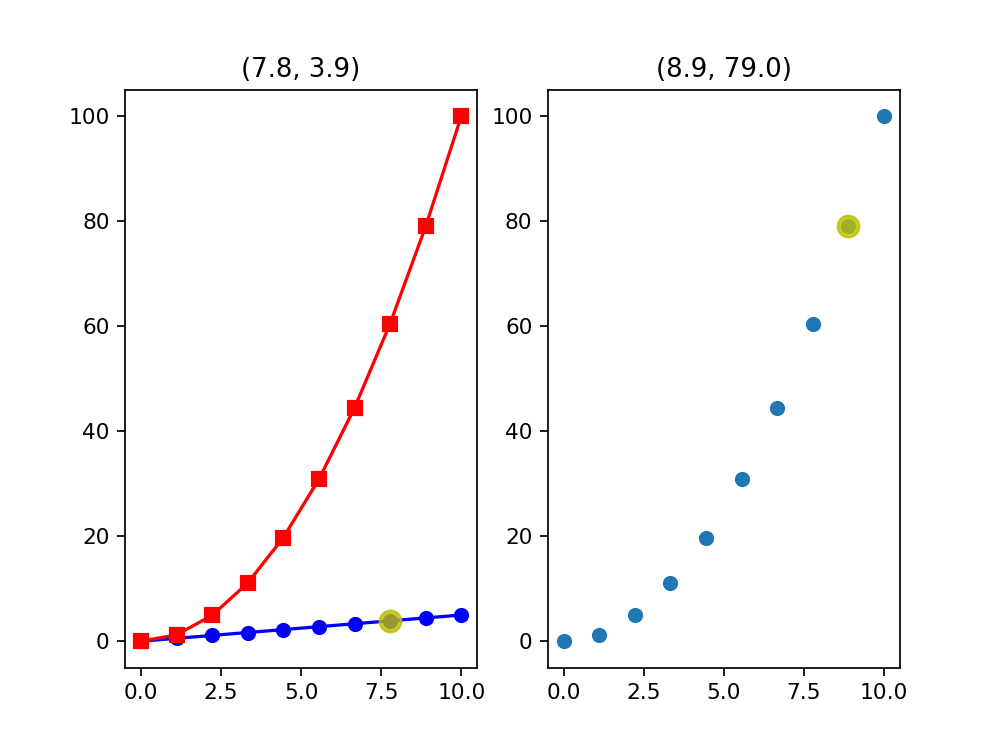

In [30]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

fig, (ax0, ax1) = plt.subplots(1, 2)

x = np.linspace(0, 10, 10)

ax0.plot(x, 0.5 * x, 'bo-', x, x**2, 'rs-', picker=5)
ax1.scatter(x, x**2, picker=5)

# Store the markers we want in variables so we can use them in our callback function
marker0, = ax0.plot(0, 0, 'yo', visible=False, alpha=0.8, ms=10)
marker1, = ax1.plot(1, 1, 'yo', visible=False, alpha=0.8, ms=10)


def onpick(event):
    # we assume you want the first point in the list
    ind = event.ind[0]

    # Get the relevant data
    if isinstance(event.artist, matplotlib.lines.Line2D):
        x = event.artist.get_xdata()
        y = event.artist.get_ydata()

    elif isinstance(event.artist, matplotlib.collections.PathCollection):
        data = event.artist.get_offsets()
        x, y = data.T

    # get the relevant axes marker
    if event.artist.axes == ax0:
        marker = marker0
        ax0.set_title(f'({x[ind]:1.1f}, {y[ind]:1.1f})')
    else:
        marker = marker1
        ax1.set_title(f'({x[ind]:1.1f}, {y[ind]:1.1f})')

    marker.set_visible(True)
    marker.set_xdata(x[ind])
    marker.set_ydata(y[ind])
    fig.canvas.draw() # Make sure you redraw the canvas to see the change

fig.canvas.mpl_connect('pick_event', onpick)
plt.show()

## Summary



We learned how to read data from an Excel file today. Since this data is not well structured, it was a manual task.

We also learned how to do some simple interactive visualizations. These are very powerful, but come at some costs to you:

1.  They are more complex to code.



## Exercises



1.  Think of an interactive plot you could make and try making it.

